> # Resnet 34, dropout 0.5, tail (1000, 200, 4), 120 epochs, mixup(prob 0.5, coef 0.2) + rot180, random crop, 1 fold 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import os
import gc
from matplotlib import pyplot as plt
import torchvision
import torch
from torchvision import transforms, models
from torch import nn 
from torch import optim
from torch.nn import functional as F
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from PIL import Image, ImageMath
import time
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
        
input_directory = "/kaggle/input/plant-pathology-2020-fgvc7/"
images_directory = "/kaggle/input/plantpathologyresize/"

In [2]:
train_csv = pd.read_csv(input_directory + "train.csv")
test_csv = pd.read_csv(input_directory + "test.csv")
number_of_images = 1821
labels = torch.argmax(torch.Tensor(train_csv.values[:, 1:].astype(float)), 1)

## Augmentation

In [3]:
train_transform = transforms.Compose([transforms.RandomVerticalFlip(),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomCrop(224),
                                    transforms.RandomAffine(180, resample = Image.BILINEAR),
                                    transforms.ToTensor()])
mixup_transform = transforms.Compose([transforms.RandomVerticalFlip(),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomCrop(224),
                                    transforms.ToTensor()])
testval_transform = transforms.Compose([transforms.CenterCrop(224),
                                        transforms.ToTensor()])

<Figure size 432x288 with 0 Axes>

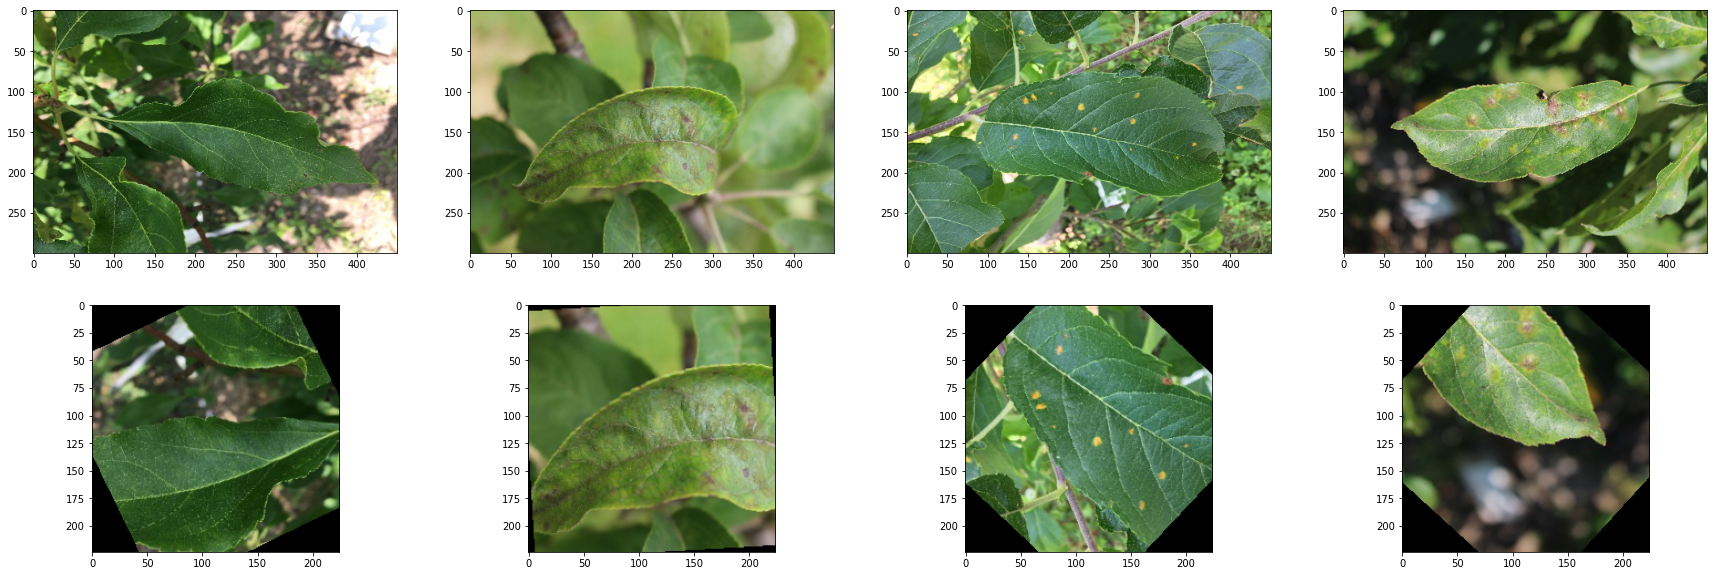

In [4]:
plt.figure()
fig, ax = plt.subplots(2, 4, figsize = (30, 10))
for i in range(4):
    index = int(np.random.random() * number_of_images)
    im = Image.open(f"/kaggle/input/plantpathologyresize/Train_{index}.jpg")
    ax[0][i].imshow(im)    
    a = train_transform(im)
    ax[1][i].imshow(a.numpy().transpose(1, 2, 0))

## Data Loader

In [5]:
class Loader:
    def __init__(self, type_, index_list = None, ld_transform = None):
        self.type_ = type_
        self.index_list = index_list
        self.transform = ld_transform
    def __getitem__(self, idx):
        if (self.type_ == 'train'):
            idx = self.index_list[idx]
            im = Image.open(images_directory + f"Train_{idx}.jpg")
            if (np.random.random() < 0.5):
                mixup_idx = self.index_list[int(np.random.random() * len(self.index_list))]
                mixup_im = Image.open(images_directory + f"Train_{mixup_idx}.jpg")
                mixup_coef = 0.8
                im = mixup_coef * mixup_transform(im)
                mixup_im = (1 - mixup_coef) * mixup_transform(mixup_im)
                return (im + mixup_im, labels[idx])
            else:
                return (train_transform(im), labels[idx])                
        elif (self.type_ == 'val'):
            idx = self.index_list[idx]
            im = Image.open(images_directory + f"Train_{idx}.jpg")
            return (testval_transform(im), labels[idx])
        else:
            im = Image.open(images_directory + f"Test_{idx}.jpg")
            return testval_transform(im)
    def __len__(self):
        if (self.type_ == 'train'):
            return len(self.index_list)
        elif (self.type_ == 'val'):
            return len(self.index_list)
        else:
            return number_of_images

## Model

In [6]:
class Network(nn.Module):
    def __init__(self): 
        super(Network, self).__init__()
        self.sota = models.resnet34(pretrained = True)
        self.fc1 = nn.Linear(1000, 200)
        self.fc2 = nn.Linear(200, 4)
        self.dropout = nn.Dropout(0.5)
        self.batchnorm1 = nn.BatchNorm1d(200)
    def forward(self, x):
        x = self.sota(x)
        x = self.dropout(F.relu(x))
        x = self.batchnorm1(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x
    def compute_flatten_size(self, x):
        self.flatten_size = x[0].detach().numpy().flatten().shape[0]

In [7]:
if (torch.cuda.is_available()):
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
criterion = nn.CrossEntropyLoss(weight = torch.Tensor([0.2, 0.4, 0.2, 0.2]).to(device))
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.1, patience = 10)

# Nessesary functions and adjustments

In [8]:
def computeROCAUC(loader, size):
    true = np.zeros(size)
    target = np.zeros((4, size))
    for i, data in enumerate(loader):
        images, groundtruth = (data[0].to(device), data[1])
        preds = net(images.float()).transpose(0, 1).cpu()
        true[i * batch_size : i * batch_size + groundtruth.cpu().shape[0]] = groundtruth.cpu().detach().numpy()
        target[:, i * batch_size : i * batch_size + groundtruth.cpu().shape[0]] = preds.cpu().detach().numpy()
    roc_auc_healthy = roc_auc_score(true == 0, target[0])
    roc_auc_multiple = roc_auc_score(true == 1, target[1])
    roc_auc_rust = roc_auc_score(true == 2, target[2])
    roc_auc_scab = roc_auc_score(true == 3, target[3])
    roc_auc_mean = (roc_auc_healthy + roc_auc_multiple + roc_auc_rust + roc_auc_scab) / 4
    return roc_auc_mean

## K-Fold Training

In [9]:
gc.collect()

132

In [10]:
one_fold = True
folds_rocauc = []
kfold = StratifiedKFold(5, shuffle = True)
nets = []
for i, (train_indeces, val_indeces) in enumerate(kfold.split(np.zeros(number_of_images), labels)):
    print("Fold #" + str(i + 1))
    net = Network().to(device)
    optimizer = optim.Adam(net.parameters(), lr = 0.001)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [50, 80, 110, 130], 0.1)
    batch_size = 48
    train_loader = torch.utils.data.DataLoader(Loader('train', train_indeces), batch_size = batch_size)
    validation_loader = torch.utils.data.DataLoader(Loader('val', val_indeces), batch_size = batch_size)
    test_loader = torch.utils.data.DataLoader(Loader('test'), batch_size = batch_size)
    
    for epochs in range(150):
        running_loss = 0  
        for data in train_loader:
            images, groundtruth = (data[0].to(device), data[1].to(device))
            optimizer.zero_grad()
            preds = net(images.float())
            loss = criterion(preds, groundtruth)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print('\n[%d] loss: %.3f' % (epochs + 1, running_loss / 10), end = "")
        if (epochs % 5 == 4):
            with torch.no_grad():
                net.eval()
                print("    Train ROC AUC: " + str(computeROCAUC(train_loader, len(train_indeces))), end = "   ")
                print("Test ROC AUC: " + str(computeROCAUC(validation_loader, len(val_indeces))), end = "")
                net.train()
        scheduler.step()
    nets.append(net)
    if (one_fold):
        break
print("ROC AUC mean over folds: " + str(np.mean(folds_rocauc)))

Fold #1


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth




[1] loss: 2.405
[2] loss: 1.944
[3] loss: 1.754
[4] loss: 1.515
[5] loss: 1.574    Train ROC AUC: 0.8600961547792182   Test ROC AUC: 0.8559110516040191
[6] loss: 1.422
[7] loss: 1.445
[8] loss: 1.356
[9] loss: 1.279
[10] loss: 1.182    Train ROC AUC: 0.9101233498996931   Test ROC AUC: 0.9128255596543224
[11] loss: 1.439
[12] loss: 1.214
[13] loss: 1.210
[14] loss: 1.217
[15] loss: 1.231    Train ROC AUC: 0.9189238208561741   Test ROC AUC: 0.9092994369639356
[16] loss: 1.160
[17] loss: 1.128
[18] loss: 1.092
[19] loss: 1.158
[20] loss: 1.155    Train ROC AUC: 0.9276834404309172   Test ROC AUC: 0.9206284471041083
[21] loss: 1.045
[22] loss: 1.033
[23] loss: 0.945
[24] loss: 1.066
[25] loss: 0.945    Train ROC AUC: 0.9277469199848288   Test ROC AUC: 0.9257468228459216
[26] loss: 1.004
[27] loss: 0.937
[28] loss: 1.004
[29] loss: 0.980
[30] loss: 0.932    Train ROC AUC: 0.9385275172160523   Test ROC AUC: 0.92204101768951
[31] loss: 1.171
[32] loss: 0.926
[33] loss: 0.935
[34] loss: 0.966

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [11]:
def test_prob():
    res = np.zeros((number_of_images, 4))
    rust_accuracy = []
    scab_accuracy = []
    for i, test_data in enumerate(test_loader, 0):
        images = test_data.to(device)
        with torch.no_grad():
            preds = np.zeros((len(nets), len(test_data), 4))
            for j in range(len(nets)):
                net = nets[j]
                net.eval()
                preds[j] = (torch.nn.Softmax()(net(images.float()))).cpu()
            res[i * batch_size: min(number_of_images, (i + 1) * batch_size), :] = np.mean(preds, 0)
    return res

In [12]:
results = test_prob()
df = pd.DataFrame({"image_id" : [f"Test_{i}" for i in range(number_of_images)], 
                  "healthy" : results[:, 0],
                  "multiple_diseases" : results[:, 1],
                  "rust" : results[:, 2],
                  "scab" : results[:, 3],})

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


In [13]:
df.to_csv("submission.csv", index = False)

Resnet
    
* Rotate 180 - shear 30 - scale 1-1.3                                                          ~    0.939 (lb)
* Rotate 180                                                                                   ~    0.946 (lb)
* Rotate 180 - center crop                                                                     ~    0.938 (lb)
* Rotate 180 - center crop - shear 30                                                          ~    0.927 (lb)  0.88(public)
* Resnet 80 epoch                                                                              ~    0.926 (lb)
* Rotate 180 - Resnet 80 epoch                                                                 ~    0.929 (lb)
* Rotate 180 - cencrop Resnet 80ep                                                             ~    0.944 (lb)  0.913(public)

  Starting from here, images size is 450 x 300
  
* Rot 180, randcrop, scale 0.7-1.2, resnet50, 80ep                                             ~    0.939 (lb)  0.935(public)  
* Rot 180, randcrop, scale 0.7-1.2, resnet50, 100ep                                            ~    0.934 (lb)  
* Rot 180, randcrop, scale 0.7-1.2, resnet50, 100ep                                            ~    0.923 (lb)
* Rot 180, randcrop, scale 1-1.2, resnet101, 200ep                                             ~    0.86 (lb)

DenseNet 161

* Rot 180, randcrop                                                                            ~    0.988 (lb)   0.935 (public)
* Rot 180, randcrop + SGD, 180 epoch                                                           ~    0.5 (lb)
* Rot 180 + scale 0.9 - 1.2, randcrop + adamax, 120 ep                                         ~    0.90 (lb)
* Rot 180, randcrop + adam, 120 ep                                                             ~    0.927 (lb)
* Rot 180, randcrop, mixup(0.5, 0.2), dropout 0.7, tail(1000, 200, 4), 120 ep                  ~    0.922 (lb)

DenseNet121

* Rot 180, randcrop, dropout 0.5, 120 ep                                                       ~    0.948 (lb)   0.939 (public)
* Rot 180, randcrop, mixup(0.7, 0.2), dropout 0.5, 120 ep                                      ~    0.955 (lb)   0.930 (public)           ?
* Rot 180, randcrop, mixup(0.8, 0.1), dropout 0.5, 120 ep                                      ~    0.961 (lb)   0.937 (public)           ?
* Rot 180, randcrop, mixup(0.8, 0.2), dropout 0.5, 120 ep                                      ~    0.960 (lb)   0.934 (public)
* Rot 180, randcrop, mixup(0.5, 0.2), dropout 0.5, 120 ep                                      ~    0.945 (lb)   0.945 (public)
* Rot 180, randcrop, mixup(0.5, 0.2), dropout 0.5, tail(1000, 100, 4), 120 ep                  ~    0.979 (lb)   0.955 (public)
* Rot 180, randcrop, mixup(0.5, 0.2), dropout 0.4, tail(1000, 4), 120 ep                       ~    0.971 (lb)   0.951 (public)
* Rot 180, randcrop, mixup(0.5, 0.2), dropout 0.7, tail(1000, 4), 120 ep                       ~    0.953 (lb)
* Rot 180, randcrop, mixup(0.5, 0.2), dropout 0.7, tail(1000, 1000, 4), 120 ep                 ~    0.959 (lb)   0.952 (public)
* Rot 180, randcrop, mixup(0.5, 0.2), dropout 0.7, tail(1000, 200, 4), 120 ep                  ~    0.975 (lb)   0.951 (public)
